## Functions / Imports

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
pd.options.mode.chained_assignment = None  # default='warn'


def str_to_int(x):
    '''Transform class4 to numeric labels.'''
    if x=="nonevent":
        return 0 
    elif x=="Ia":
        return 1
    elif x=="Ib":
        return 2
    else:
        return 3


def int_to_str(x):
    '''Transform class 4 back to events.'''
    if x==0:
        return "nonevent"
    elif x==1:
        return "Ia"
    elif x==2:
        return "Ib"
    else:
        return "II"
    

def read_data(path="../data/npf_train.csv"):
    '''Read train/test data. Returns filtered out normalized data.'''
    data = pd.read_csv(path)                                                        # read the data
    class4 = list(map(lambda x: int(str_to_int(x)), data["class4"]))                # encode events into integers
    data = data.drop(columns=["id", "partlybad", "date", "class4"])                 # drop unnecessary columns
    data = data.iloc[:,[0,10,22,24,36,48,58,60,62,64,66,78,80,82,84,94,96,98]]      # choose important variables
    data = (data-data.mean()) / data.std()                                          # normalize the data
    data["class4"] = class4
    
    return data


def report_accuracies(y_pred, y_test, verbose=True):
    '''Calculate each class accuracy. Return multi class and binary accuracies.'''
    acc_0 = 0; acc_1 = 0; acc_2 = 0; acc_3 = 0 
    for i in range(len(y_pred)):
        if y_test[i] == 0 and y_pred[i] == 0:
            acc_0 += 1
        elif y_test[i] == 1 and y_pred[i] == 1:
            acc_1 += 1
        elif y_test[i] == 2 and y_pred[i] == 2:
            acc_2 += 1
        elif y_test[i] == 3 and y_pred[i] == 3:
            acc_3 += 1
            
    acc0 = acc_0 / (np.mean(y_test == 0)*len(y_test))
    acc1 = acc_1 / (np.mean(y_test == 1)*len(y_test))
    acc2 = acc_2 / (np.mean(y_test == 2)*len(y_test))
    acc3 = acc_3 / (np.mean(y_test == 3)*len(y_test))
    acc = np.mean(y_test==y_pred)
    
    if verbose:
        print(f"Accuracy for nonevent = {acc0:.4f} \t({acc_0}/{int((np.mean(y_test == 0)*len(y_test)))})")
        print(f"Accuracy for event Ia = {acc1:.4f} \t({acc_1}/{int((np.mean(y_test == 1)*len(y_test)))})")
        print(f"Accuracy for event Ib = {acc2:.4f} \t({acc_2}/{int((np.mean(y_test == 2)*len(y_test)))})")
        print(f"Accuracy for event II = {acc3:.4f} \t({acc_3}/{int((np.mean(y_test == 3)*len(y_test)))})")
        print(f"Accuracy overall = {acc:.4f}")

    # calculate binary accuracy
    for i, y in enumerate(y_pred):
        if y != 0:
            y_pred[i] = 1
        if y_test[i] != 0:
            y_test[i] = 1
            
    bin_acc = np.mean(y_pred == y_test)
    
    return acc, bin_acc


def split_train_test(data, a=0.5):
    '''Split each class evenly.'''
    data = data.sample(frac=1)
    X_nonevent, y_nonevent = data.loc[data["class4"] == 0].drop(columns=["class4"]).values, data["class4"].loc[data["class4"] == 0].values
    X_Ia, y_Ia = data.loc[data["class4"] == 1].drop(columns=["class4"]).values, data["class4"].loc[data["class4"] == 1].values
    X_Ib, y_Ib = data.loc[data["class4"] == 2].drop(columns=["class4"]).values, data["class4"].loc[data["class4"] == 2].values
    X_II, y_II = data.loc[data["class4"] == 3].drop(columns=["class4"]).values, data["class4"].loc[data["class4"] == 3].values

    # Split each class into equal size train and test
    X_nonevent_train, X_nonevent_test, y_nonevent_train, y_nonevent_test = train_test_split(X_nonevent, y_nonevent, test_size=a)
    X_Ia_train, X_Ia_test, y_Ia_train, y_Ia_test = train_test_split(X_Ia, y_Ia, test_size=a)
    X_Ib_train, X_Ib_test, y_Ib_train, y_Ib_test = train_test_split(X_Ib, y_Ib, test_size=a)
    X_II_train, X_II_test, y_II_train, y_II_test = train_test_split(X_II, y_II, test_size=a)

    # Recreate the mixed class train and test data (full data)
    X_train = np.vstack([X_nonevent_train, X_Ia_train, X_Ib_train, X_II_train])
    X_test = np.vstack([X_nonevent_test, X_Ia_test, X_Ib_test, X_II_test])
    y_train = np.hstack([y_nonevent_train, y_Ia_train, y_Ib_train, y_II_train])
    y_test = np.hstack([y_nonevent_test, y_Ia_test, y_Ib_test, y_II_test])
    
    return X_train, X_test, y_train, y_test

## Read data

In [24]:
data = read_data()
data.shape

(458, 19)

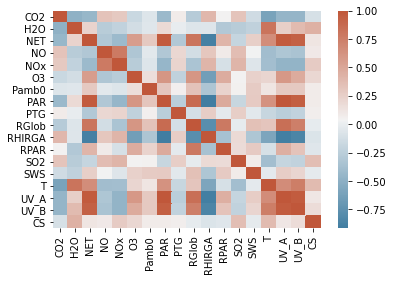

In [31]:
import seaborn as sns
X = read_data().drop(columns="class4")
for c in X.columns:
    if ".mean" in c:
        X = X.rename(columns={str(c):str(c)[:-5]})
X = X.rename(columns={"CO2168":"CO2", "H2O168":"H2O", "NO168":"NO", "NOx168":"NOx", "O3168":"O3", "RHIRGA168":"RHIRGA", 
                      "SO2168":"SO2", "T168":"T"})

correlation = X.loc[:,['std' not in i for i in X.columns]].corr()
heatmap = sns.heatmap(correlation, cmap = sns.diverging_palette(235, 21, as_cmap=True))
fig = heatmap.get_figure()

plt.show()

In [32]:
fig.savefig('final_heatmap.png', dpi=600, bbox_inches='tight')

## Prepare X, y and fit SVM

In [13]:
X, y = data.drop(columns="class4").values, data.class4.values

svm = SVC(kernel='rbf', C=3.75, tol=1e-8)
scores = cross_val_score(svm, X, y, cv=5)
print(f"Mean accuracy (5-fold CV): {np.mean(scores):.4f}")

Mean accuracy (5-fold CV): 0.6661


## Performance on hidden test

In [37]:
X_train.shape

(458, 15)

In [40]:
train_data = read_data()

X_train = data.drop(columns="class4").values
X_train.shape

(458, 15)

In [43]:
train_data = read_data()
test_data = read_data(path="npf_test.csv")

X_train, y_train = train_data.drop(columns="class4").values, data.class4.values
X_test, y_test = test_data.drop(columns="class4").values, test_data.class4.values

clf = SVC(kernel='rbf', C=500, tol=1e-8)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
report_accuracies(y_pred, y_test)

Accuracy for nonevent = 0.9136 	(465/509)
Accuracy for event Ia = 0.5625 	(27/48)
Accuracy for event Ib = 0.6071 	(102/168)
Accuracy for event II = 0.6083 	(146/240)
Accuracy overall = 0.7668


(0.7668393782383419, 0.910880829015544)

In [15]:
accs = []
for i in range(1000):
    data = read_data()
    data = read_data(path="npf_train.csv")

    X_train, X_test, y_train, y_test = split_train_test(data, a=0.5)

    y_train = np.array(list(map(lambda x: 1 if int(x)!=0 else int(x), y_train)), dtype=np.int32)
    y_test = np.array(list(map(lambda x: 1 if int(x)!=0 else int(x), y_test)), dtype=np.int32)

    clf = SVC(kernel="rbf", C=3.75, tol=1e-8)
    #clf = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000000)
    #clf = LogisticRegression(solver='lbfgs')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accs.append(np.mean(y_pred==y_test))
    
np.mean(accs), np.std(accs)

(0.8571861471861472, 0.01902985200494403)

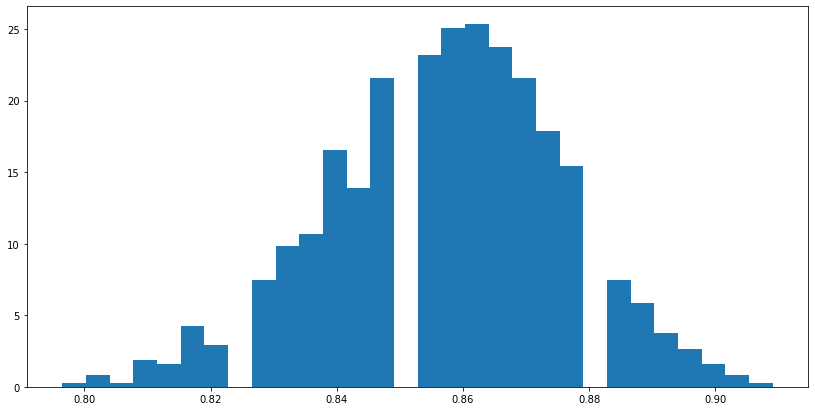

In [6]:
plt.figure(figsize=(14,7))
plt.hist(accs, bins=30, density=True)
plt.show()

## Fit 1000 SVMs 

In [35]:
def cv(estimator, data, k=100, a=0.5):
    '''k: number of SVMs trained
       a: test_size when splitting into train/test.'''
    scores = []
    bin_scores = []
    
    for _ in range(k):
        X_train, X_test, y_train, y_test = split_train_test(data, a=a)
        
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        
        acc, acc0 = report_accuracies(y_pred, y_test, verbose=0)
        scores.append(acc)
        bin_scores.append(acc0)
    
    return scores, bin_scores

data = read_data()
data = data.drop(columns=["PAR.mean", "UV_B.mean", "NET.mean"])
clf = SVC(C=3.75, kernel="rbf", tol=1e-5)

k=10000
scores, bin_scores = cv(clf, data, k)
print(f"Training {k} SVMs...")
print(f"Average accuracy = {np.mean(scores):.4f}")
print(f"Maximum accuracy = {np.max(scores):.4f}")
print(f"Average accuracy for binary task = {np.mean(bin_scores):.4f}")
print(f"Maximum accuracy for binary task = {np.max(bin_scores):.4f}")

Training 10000 SVMs...
Average accuracy = 0.6559
Maximum accuracy = 0.7403
Average accuracy for binary task = 0.8448
Maximum accuracy for binary task = 0.9091


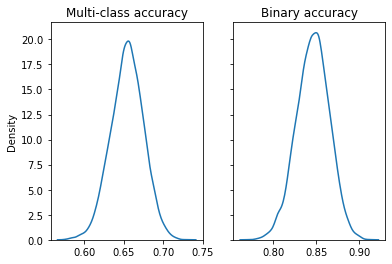

In [19]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey= True)
sns.kdeplot(x = scores, ax = ax1).set(title = "Multi-class accuracy")
sns.kdeplot(x = bin_scores, ax = ax2).set(title = "Binary accuracy")
plt.show()

In [20]:

fig.savefig('average_accuracies.png', dpi=600, bbox_inches='tight')

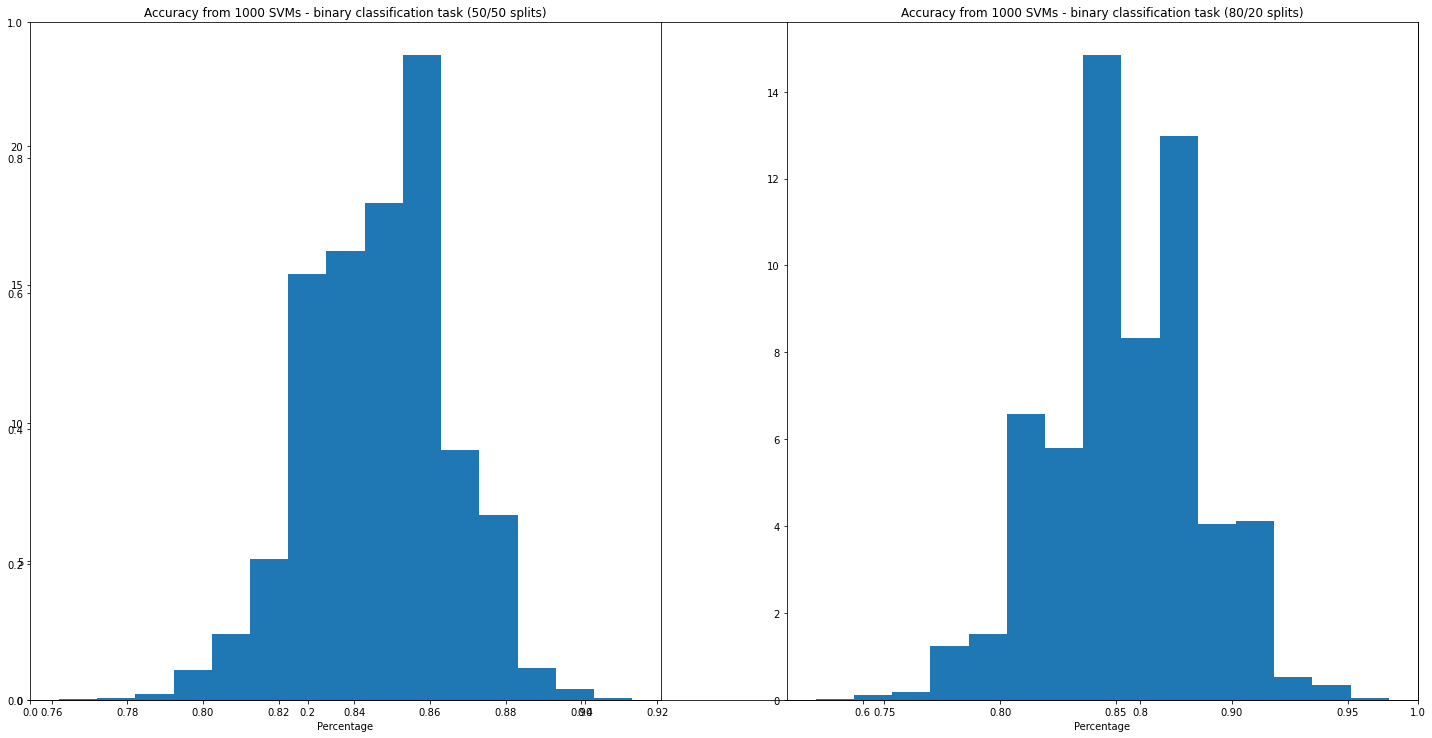

In [8]:
_, bin_scores_1 = cv(clf, data, k=10000)
_, bin_scores_2 = cv(clf, data, k=10000, a=0.2)

fig, ax = plt.subplots(figsize=(20, 10))
plt.tight_layout()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(bin_scores_1, bins=15, density=True)
ax2.hist(bin_scores_2, bins=15, density=True)

ax1.set_title("Accuracy from 1000 SVMs - binary classification task (50/50 splits)")
ax1.set_xlabel("Percentage")
ax2.set_title("Accuracy from 1000 SVMs - binary classification task (80/20 splits)")
ax2.set_xlabel("Percentage")

#fig.savefig('image.png', format='png', dpi=1200)

plt.show()

In [9]:
fig.savefig('image600.png', format='png', dpi=600)

## Calculate probabilities and labels for answers.csv

In [10]:
predicted_probabilities[:20]

NameError: name 'predicted_probabilities' is not defined

In [ ]:
train_data = read_data()
test_data = read_data(path="npf_test.csv")

X_train, y_train = data.drop(columns="class4").values, data.class4.values
X_test, y_test = test_data.drop(columns="class4").values, test_data.class4.values

clf = SVC(C=3.75, kernel="rbf", tol=1e-5, probability=True)
clf.fit(X_train, y_train)
predicted_probabilities = clf.predict_proba(X_test)

labels = []
p = []
for row in predicted_probabilities:
    prob = np.max(row)
    label = int(np.argmax(row))
    label = int_to_str(label)
    if label=="nonevent":
        prob = 1-prob
    prob=round(prob,2)
    labels.append(label)
    p.append(prob)

answers = pd.DataFrame(labels, columns=["class4"])
answers["p"] = p

## Write to answers.csv

In [ ]:
# Write answers
with open("answers.csv", "w") as f:
    f.write("0.87\n")
    answers.to_csv(f, index=False, line_terminator='\n')

## Sanity checks

In [ ]:
answers["class2"].loc[(answers.p > 0.5) & (answers.class4 == "nonevent")] = "event"

In [ ]:
np.mean(answers.class2 == test_data.class2)

In [ ]:
answers = pd.read_csv("answers.csv", header=1)
answers["class2"] = "event"
answers["class2"].loc[answers.class4 == "nonevent"] = "nonevent"
answers.head()

In [ ]:
test_data = read_data(path="npf_test.csv")
test_data["class2"] = "event"
test_data["class4"] = list(map(lambda x: int_to_str(x), test_data["class4"]))
test_data["class2"].loc[test_data.class4 == "nonevent"] = "nonevent"
test_data.loc[:,["class4","class2"]].head()

## See where predicted and true labels don't match

In [ ]:
answers["class4_npf"] = test_data.class4
answers["class2_npf"] = test_data.class2
answers.loc[answers.class2 != test_data.class2].head(20)